## Training a Neural Network Model

- using `pytorch`

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [1]:
import sys
import os

# Add the path to the 'code' directory
sys.path.append(os.path.abspath('../code'))

In [32]:
import pandas as pd
import json
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

# include feature engineering pipeline
from feature_eng_pipeline import pipeline_nn

In [3]:
# switch to using CUDA - GPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
torch.cuda.is_available()

True

In [26]:
# loading data
data_path = '../../data/mean_with_labels.csv'

class RNANanoporeDataset(Dataset):
    """Dataset used to train and test RNA Nanopore data"""

    def __init__(self, csv_file):
        """Initializes instance of class RNANanoporeDataset.

        Args:
            csv_file (str): Path to the csv file with the nanopore data
        """

        self.df = pd.read_csv(csv_file)
        v, s, X_df, y_df = pipeline_nn(self.df)
        #X_drop = X_df.drop(["transcript_name", "gene_id", "nucleotide_seq"], axis=1).reset_index(drop=True)  

        # keep all trigram columns in input dataset
        self.X = X_df
        self.y = y_df.reset_index(drop=True).squeeze()  

    def __len__(self):
        """Returns the size of the dataset"""
        return len(self.X)

    def __getitem__(self, idx):
    # Handle if idx is a tensor (converting to list if needed)
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()

        signal_features = self.X.iloc[idx].values  
        label = self.y.iloc[idx]  

        # Convert to tensors
        signal_features = torch.tensor(signal_features, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        return signal_features, label
    
    def get_size(self):
        return len(self)


In [21]:
dataset = RNANanoporeDataset(data_path)

# split data by 80-20
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = random_split(dataset, [train_size, test_size])

# Dataloaders
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

In [42]:
class ModNet(nn.Module):
    def __init__(self, signal_input_dim):
        super(ModNet, self).__init__()

        # Read-level Encoder: MLP with two hidden layers
        self.encoder = nn.Sequential(
            nn.Linear(signal_input_dim, 150),  # Change hidden dimensions as needed
            nn.ReLU(),
            nn.Linear(150, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Single output for binary classification
        )

    def forward(self, signal_features):
        read_level_probs = self.encoder(signal_features)
        return torch.sigmoid(read_level_probs)  # Apply sigmoid for probabilities

    def noisy_or_pooling(self, read_level_probs):
        """
        :param read_level_probs: Tensor of shape (batch_size, 1)
        :return: Site-level modification probability for each site (batch_size, 1)
        """
        site_level_probs = 1 - torch.prod(1 - read_level_probs, dim=1)
        return site_level_probs


In [43]:
# Set CUDA launch blocking for better error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [44]:
# based on dataset size
model = ModNet(signal_input_dim=dataset.get_size()) 

# Binary Cross-Entropy Loss for binary classification
criterion = nn.BCEWithLogitsLoss() 

# Modified optimizer with gradient clipping
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [45]:
def train_model_with_checks(model, trainloader, criterion, optimizer, num_epochs=10, clip_value=1.0):
    """
    Training loop with additional checks to prevent NaN losses
    """
    model.to(device) 
    model.train()
    
    # Track losses for monitoring
    all_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for i, data in enumerate(trainloader, 0):
            signal_features, labels = data
            signal_features = signal_features.to(device)
            labels = labels.to(device).float()

            # Zero gradients
            optimizer.zero_grad()
            
            try:
                # Forward pass
                outputs = model(signal_features)
                loss = criterion(outputs, labels.view(-1, 1))
                
                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                optimizer.step()
                
                # Track loss
                all_losses.append(loss.item())
                running_loss += loss.item()
                
                if i % 10 == 9:
                    avg_loss = running_loss / 10
                    print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}], Loss: {avg_loss:.4f}')
                    running_loss = 0.0
                    
            except RuntimeError as e:
                print(f"Runtime Error in batch {i}:", e)
                continue
    
    return all_losses

# Additional helper functions for model debugging
def check_model_weights(model):
    """Check if model weights are properly initialized"""
    for name, param in model.named_parameters():
        print(f"\nLayer: {name}")
        print(f"Shape: {param.shape}")
        print(f"Mean: {param.mean().item():.4f}")
        print(f"Std: {param.std().item():.4f}")
        print(f"Min: {param.min().item():.4f}")
        print(f"Max: {param.max().item():.4f}")

def initialize_weights(model):
    """Initialize model weights properly"""
    for m in model.modules():
        if isinstance(m, (torch.nn.Linear, torch.nn.Conv1d)):
            torch.nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)

losses = train_model_with_checks(model, trainloader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Batch [10], Loss: 0.7235
Epoch [1/10], Batch [20], Loss: 0.7078
Epoch [1/10], Batch [30], Loss: 0.6923
Epoch [1/10], Batch [40], Loss: 0.6905
Epoch [1/10], Batch [50], Loss: 0.6864
Epoch [1/10], Batch [60], Loss: 0.6877
Epoch [1/10], Batch [70], Loss: 0.6857
Epoch [1/10], Batch [80], Loss: 0.6814
Epoch [1/10], Batch [90], Loss: 0.6802
Epoch [1/10], Batch [100], Loss: 0.6742
Epoch [1/10], Batch [110], Loss: 0.6740
Epoch [1/10], Batch [120], Loss: 0.6667
Epoch [1/10], Batch [130], Loss: 0.6688
Epoch [1/10], Batch [140], Loss: 0.6549
Epoch [1/10], Batch [150], Loss: 0.6542
Epoch [1/10], Batch [160], Loss: 0.6504
Epoch [1/10], Batch [170], Loss: 0.6400
Epoch [1/10], Batch [180], Loss: 0.6420
Epoch [1/10], Batch [190], Loss: 0.6340
Epoch [1/10], Batch [200], Loss: 0.6421
Epoch [1/10], Batch [210], Loss: 0.6313
Epoch [1/10], Batch [220], Loss: 0.6274
Epoch [1/10], Batch [230], Loss: 0.6299
Epoch [1/10], Batch [240], Loss: 0.6242
Epoch [1/10], Batch [250], Loss: 0.6243
Epoch [1/

In [46]:
# Function to evaluate on the test set
def evaluate_model(model, testloader, criterion):
    model.eval()  
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in testloader:
            signal_features, labels = data
            
            # Move data to device
            signal_features = signal_features.to(device)
            labels = labels.to(device)
            
            # Forward pass
            read_level_probs = model(signal_features)
            site_level_probs = model.noisy_or_pooling(read_level_probs).squeeze()  # Shape: (batch_size,)

            # Compute loss
            loss = criterion(site_level_probs, labels.float())
            total_loss += loss.item()

            # Collect predictions and labels for ROC and PR AUC
            all_labels.append(labels.cpu())
            all_predictions.append(site_level_probs.cpu())

    # Convert lists to tensors
    all_labels = torch.cat(all_labels)
    all_predictions = torch.cat(all_predictions)

    # Compute ROC-AUC and PR-AUC
    roc_auc = roc_auc_score(all_labels, all_predictions)
    precision, recall, _ = precision_recall_curve(all_labels, all_predictions)
    pr_auc = auc(recall, precision)

    # Average loss
    avg_loss = total_loss / len(testloader)
    
    print(f'Test Loss: {avg_loss:.4f}, ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}')
    
    return avg_loss, roc_auc, pr_auc

evaluate_model(model, testloader, criterion)

Test Loss: 0.5748, ROC-AUC: 0.9318, PR-AUC: 0.9312


(0.5748005570787372,
 np.float64(0.9317936041504671),
 np.float64(0.9312429731936049))

## Saving and Loading Model, with Full Dataset Predictions

In [52]:
def save_model(model, save_dir="../models/", pth_file="model.pth"):
    """
    Save the trained model
    
    Args:
        model: trained PyTorch model
        save_dir (str): directory to save the model
        pth_file (str): name of the model file
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model state dict
    checkpoint = {
        'model_state_dict': model.state_dict()
    }
    
    # Save to file
    model_path = os.path.join(save_dir, pth_file)
    torch.save(checkpoint, model_path)
    print(f"Model saved to {model_path}")

def load_saved_model(model, save_dir="../models/", pth_file="model.pth"):
    """
    Load a saved model
    
    Args:
        model: Initialized model instance
        save_dir (str): directory where model is saved
        pth_file (str): name of the model file
    
    Returns:
        model: Loaded model
    """
    # Load checkpoint
    model_path = os.path.join(save_dir, pth_file)
    checkpoint = torch.load(model_path)
    
    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Model loaded from {model_path}")
    return model

In [54]:
# Save the model
save_model(model, pth_file="model3.pth")

# loading the saved model:
loaded_model = load_saved_model(
    model = model,  # Replace with your model class
    save_dir="../models/",
    pth_file="model3.pth"
)

Model saved to ../models/model3.pth
Model loaded from ../models/model3.pth


C:\Users\User\AppData\Local\Temp\ipykernel_8676\3353803314.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [55]:
def predict_on_full_dataset(model, dataset, batch_size=32, device='cuda'):
    """
    Make predictions on the entire dataset
    
    Args:
        model: trained PyTorch model
        dataset: full dataset
        batch_size: batch size for DataLoader
        device: device to run predictions on
    
    Returns:
        tuple: (predictions, true_labels, probabilities)
    """
    # Create DataLoader for full dataset
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Set model to evaluation mode
    model.eval()
    model = model.to(device)
    
    # Lists to store predictions and true labels
    all_predictions = []
    all_labels = []
    all_probs = []
    
    print("Making predictions on full dataset...")
    
    with torch.no_grad():
        for data in dataloader:
            signal_features, labels = data
            
            # Move data to device
            signal_features = signal_features.to(device)
            
            # Forward pass
            read_level_probs = model(signal_features)
            site_level_probs = model.noisy_or_pooling(read_level_probs).squeeze()
            
            # Store predictions and labels
            predictions = (site_level_probs > 0.5).float()
            
            all_predictions.append(predictions.cpu())
            all_labels.append(labels.cpu())
            all_probs.append(site_level_probs.cpu())
    
    # Concatenate all predictions and labels
    predictions = torch.cat(all_predictions)
    true_labels = torch.cat(all_labels)
    probabilities = torch.cat(all_probs)
    
    # Calculate metrics
    accuracy = (predictions == true_labels).float().mean()
    roc_auc = roc_auc_score(true_labels, probabilities)
    
    # Print summary statistics
    print("\nFull Dataset Prediction Results:")
    print(f"Total samples: {len(dataset)}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Create visualization
    plt.figure(figsize=(15, 5))
    
    # Distribution of prediction probabilities
    plt.subplot(1, 2, 1)
    plt.hist(probabilities[true_labels == 0], bins=50, alpha=0.5, label='No m6a', density=True)
    plt.hist(probabilities[true_labels == 1], bins=50, alpha=0.5, label='m6a', density=True)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Density')
    plt.title('Distribution of Prediction Probabilities')
    plt.legend()
    
    # ROC curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(true_labels, probabilities)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Full Dataset')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return predictions, true_labels, probabilities

# Optional: Function to analyze prediction errors
def analyze_predictions(predictions, true_labels, probabilities, dataset):
    """
    Analyze prediction errors and patterns
    
    Args:
        predictions: model predictions
        true_labels: true labels
        probabilities: prediction probabilities
        dataset: original dataset
    """
    # Find incorrect predictions
    errors = predictions != true_labels
    
    print("\nPrediction Analysis:")
    print(f"Total errors: {errors.sum()}")
    
    # False positives and negatives
    fp = ((predictions == 1) & (true_labels == 0)).sum()
    fn = ((predictions == 0) & (true_labels == 1)).sum()
    
    print(f"False positives: {fp}")
    print(f"False negatives: {fn}")
    
    # Confidence analysis
    high_conf_errors = (errors & (torch.abs(probabilities - 0.5) > 0.25)).sum()
    print(f"High confidence errors (>75% confident): {high_conf_errors}")

Making predictions on full dataset...

Full Dataset Prediction Results:
Total samples: 210583
Accuracy: 0.8931
ROC-AUC: 0.9340


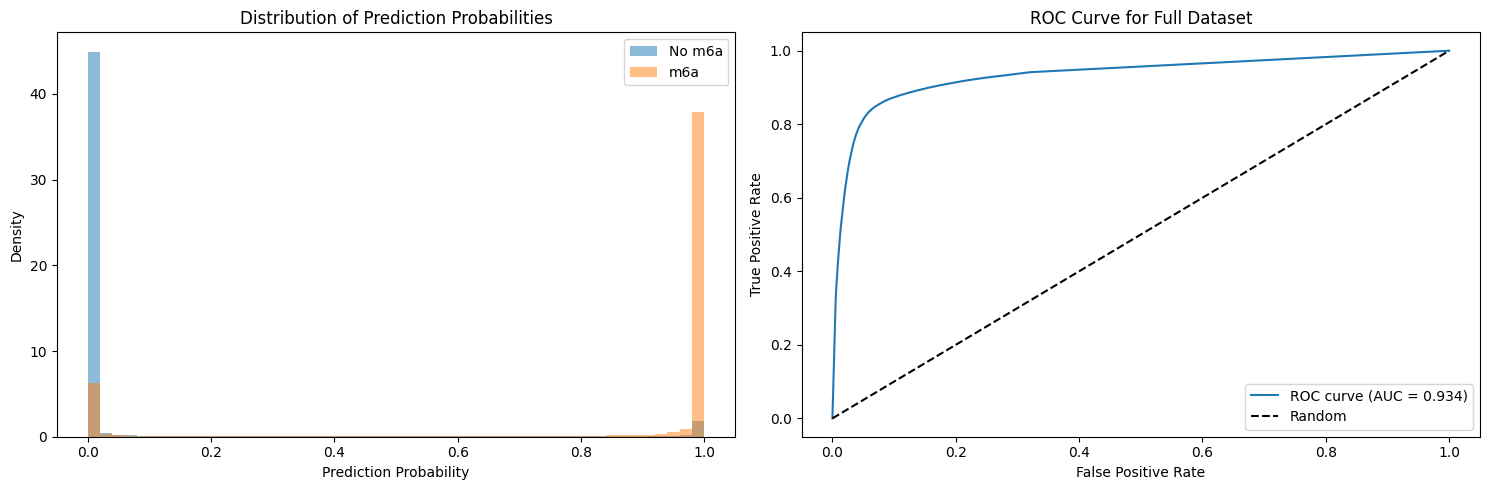


Prediction Analysis:
Total errors: 22518
False positives: 7006
False negatives: 15512
High confidence errors (>75% confident): 20283


In [56]:
# Make predictions on full dataset
predictions, true_labels, probabilities = predict_on_full_dataset(
    model=loaded_model,
    dataset=dataset,
    batch_size=32,
    device=device
)

# Analyze predictions
analyze_predictions(predictions, true_labels, probabilities, dataset)